<a href="https://colab.research.google.com/github/LaizaCostaa/sistema_de_recomendacao_ze_delivery/blob/main/sistema_de_recomendacao_ze_delivery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



### 1.   Carregamento dos dados




In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [ ]:
df_users = pd.read_csv("C:\\Users\\Laiza\\AppData\\Local\\Programs\\Microsoft VS Code\\sistema_de_recomendacao_ze_delivery\\ze_delivery_interactions.csv")


,user_id,product_id,interaction_type,interaction_time,rating
0,21,48,cart_add,2022-03-25 07:16:45.405405405,3.0
1,16,7,view,2022-09-22 03:49:11.351351352,3.0
2,43,39,view,2023-10-14 01:56:45.405405408,3.0
3,63,13,purchase,2022-03-23 02:40:00.000000000,1.0
4,8,24,cart_add,2023-03-29 16:30:16.216216216,3.0


In [16]:

df_products = pd.read_csv("C:\\Users\\Laiza\\AppData\\Local\\Programs\\Microsoft VS Code\\sistema_de_recomendacao_ze_delivery\\ze_delivery_products.csv")
df_products.head()


,product_id,product_name,category,price,brand,alcohol_content
0,1,Skol 255ml,Cerveja,8.5,Skol,4.5
1,2,Coca-Cola 293ml,Refrigerante,9.0,Coca-Cola,0.0
2,3,Heineken 426ml,Cerveja,9.5,Heineken,5.0
3,4,Pepsi 207ml,Cerveja,8.0,Pepsi,4.5
4,5,Coca-Cola 448ml,Refrigerante,9.0,Coca-Cola,0.0


#### 2. Análise exploratória

In [10]:
print(df_products.shape)
print(df_users.shape)

(50, 6)
(1000, 5)


In [11]:
inter_per_user = df_users.groupby("user_id").size()

inter_per_user.describe()

count    100.000000
mean      10.000000
std        3.527668
min        3.000000
25%        7.000000
50%        9.000000
75%       12.000000
max       20.000000
dtype: float64

In [17]:
merged = df_users.merge(df_products, on="product_id", how="left")
merged["category"].value_counts()

category
Cerveja         610
Refrigerante    253
Energético      137
Name: count, dtype: int64

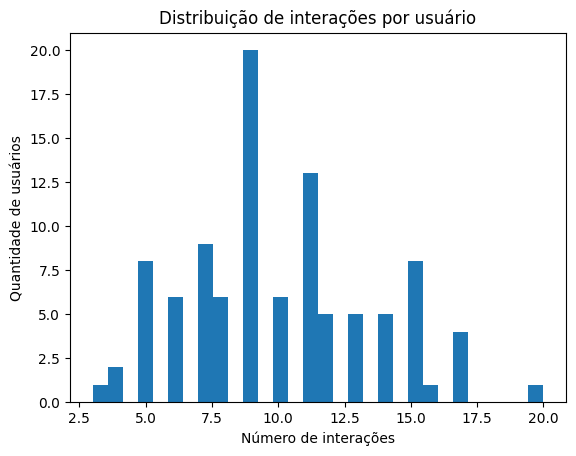

In [19]:
plt.hist(inter_per_user, bins=30)
plt.title("Distribuição de interações por usuário")
plt.xlabel("Número de interações")
plt.ylabel("Quantidade de usuários")
plt.show()

O dataset possui 100 usuários com uma média de 10 interações por usuário. A distribuição é relativamente equilibrada, com a maioria dos usuários apresentando entre 7 e 12 interações. As interações são do tipo implícito (visualização, adição ao carrinho e compra), caracterizando um cenário típico de recomendação em e-commerce. Como a maioria dos usuários possui histórico suficiente, o problema de cold start é moderado, permitindo o uso de modelos colaborativos e híbridos

#### 3. Baseline de popularidade

In [21]:
# pesos de interação
weights = {
    "view": 1.0,
    "cart_add": 3.0,
    "purchase": 6.0
}

df_users["w"] = df_users["interaction_type"].map(weights)

# agrega por user-produto
ui = (
    df_users.groupby(["user_id", "product_id"], as_index=False)
    .agg(score=("w", "sum"))
)

In [22]:
# split simples por usuário (80/20)
def split_user(df):
    train = []
    test = []
    for u, g in df.groupby("user_id"):
        g = g.sample(frac=1, random_state=42)
        cut = int(len(g) * 0.8)
        train.append(g.iloc[:cut])
        test.append(g.iloc[cut:])
    return pd.concat(train), pd.concat(test)

train_ui, test_ui = split_user(ui)

# ground truth
gt = test_ui.groupby("user_id")["product_id"].apply(set).to_dict()

# popularidade
pop = (
    train_ui.groupby("product_id")["score"]
    .sum()
    .sort_values(ascending=False)
    .index.tolist()
)

In [23]:
train_items = train_ui.groupby("user_id")["product_id"].apply(set).to_dict()

def recommend_popular(user_id, k=10):
    seen = train_items.get(user_id, set())
    out = []
    for p in pop:
        if p not in seen:
            out.append(p)
        if len(out) >= k:
            break
    return out

recs_pop = {u: recommend_popular(u, k=10) for u in gt.keys()}

In [25]:
# métricas
def recall_at_k(recs, gt, k=10):
    vals = []
    for u, true_items in gt.items():
        ranked = recs.get(u, [])[:k]
        if not true_items:
            continue
        hit = len(set(ranked) & true_items)
        vals.append(hit / len(true_items))
    return float(np.mean(vals)) if vals else 0.0

def ap_at_k(ranked, true_items, k=10):
    ranked = ranked[:k]
    hits = 0
    s = 0.0
    for i, item in enumerate(ranked, start=1):
        if item in true_items:
            hits += 1
            s += hits / i
    return s / min(len(true_items), k) if true_items else 0.0

def map_at_k(recs, gt, k=10):
    vals = []
    for u, true_items in gt.items():
        ranked = recs.get(u, [])
        vals.append(ap_at_k(ranked, true_items, k=k))
    return float(np.mean(vals)) if vals else 0.0

print("Popular baseline | Recall@10:", recall_at_k(recs_pop, gt, k=10))
print("Popular baseline | MAP@10   :", map_at_k(recs_pop, gt, k=10))

Popular baseline | Recall@10: 0.15416666666666667
Popular baseline | MAP@10   : 0.03570833333333333


- Em média, 15,4% dos itens reais do usuário aparecem nas recomendações top-10.
- O ranking ainda é fraco (MAP baixo), o que é esperado para popularidade pura

O modelo:

- Funciona como um fallback global
- Recomendaria sempre os produtos mais populares
- Não considera o gosto individual do usuário

Ou seja, todo mundo recebe praticamente as mesmas recomendações, o que é esperado para um baseline

_______________________________________________________

#### 3.1 Baseline por última categoria

O objetivo é criar um modelo simples, mas já personalizado por usuário. a ideia é melhorar o Recall aumentar o MAP

Para cada usuário:

- Pega o último produto que ele interagiu
- Descobre a categoria desse produto
- Recomenda produtos populares da mesma categoria


In [26]:
# junta com produtos para pegar categoria
train_merged = train_ui.merge(df_products, on="product_id", how="left")
test_merged = test_ui.merge(df_products, on="product_id", how="left")

# popularidade por categoria
pop_by_cat = (
    train_merged.groupby(["category", "product_id"])["score"]
    .sum()
    .reset_index()
)

cat_rank = (
    pop_by_cat.sort_values(["category", "score"], ascending=[True, False])
    .groupby("category")["product_id"]
    .apply(list)
    .to_dict()
)

# última categoria do usuário
last_cat = (
    train_merged.sort_values("score")
    .groupby("user_id")
    .tail(1)
    .set_index("user_id")["category"]
    .to_dict()
)

def recommend_by_category(user_id, k=10):
    seen = train_items.get(user_id, set())
    cat = last_cat.get(user_id, None)
    
    if cat is None:
        return recommend_popular(user_id, k)
    
    candidates = cat_rank.get(cat, [])
    
    out = []
    for p in candidates:
        if p not in seen:
            out.append(p)
        if len(out) >= k:
            break
    return out

recs_cat = {u: recommend_by_category(u, k=10) for u in gt.keys()}

print("Category baseline | Recall@10:", recall_at_k(recs_cat, gt, k=10))
print("Category baseline | MAP@10   :", map_at_k(recs_cat, gt, k=10))


Category baseline | Recall@10: 0.09833333333333333
Category baseline | MAP@10   : 0.038273148148148146


O baseline por categoria apresentou Recall@10 inferior ao modelo de popularidade, indicando que os usuários não consomem apenas dentro de uma única categoria. Apesar disso, o MAP@10 teve uma leve melhora, sugerindo que quando o modelo acerta, ele posiciona melhor os itens relevantes no ranking.
Mas já é possível ter uma base antes de apliacar o modelo colaborativo ou híbrido para capturar padrões de consumo entre usuários e produtos.

#### 4. Modelo colaborativo (Colaborative Filtering)

In [28]:
# matriz user-item
user_ids = train_ui["user_id"].unique()
prod_ids = train_ui["product_id"].unique()

user_map = {u: i for i, u in enumerate(user_ids)}
prod_map = {p: i for i, p in enumerate(prod_ids)}

rows = train_ui["user_id"].map(user_map)
cols = train_ui["product_id"].map(prod_map)
vals = train_ui["score"]

mat = csr_matrix((vals, (rows, cols)),
                 shape=(len(user_ids), len(prod_ids)))

In [29]:
# SVD
svd = TruncatedSVD(n_components=20, random_state=42)
user_factors = svd.fit_transform(mat)
item_factors = svd.components_.T

# recomendações
def recommend_svd(user_id, k=10):
    if user_id not in user_map:
        return recommend_popular(user_id, k)
    
    u_idx = user_map[user_id]
    scores = user_factors[u_idx].dot(item_factors.T)
    
    seen = train_items.get(user_id, set())
    
    ranked_idx = np.argsort(-scores)
    recs = []
    for idx in ranked_idx:
        prod = prod_ids[idx]
        if prod not in seen:
            recs.append(prod)
        if len(recs) >= k:
            break
    return recs

recs_svd = {u: recommend_svd(u, k=10) for u in gt.keys()}

print("SVD | Recall@10:", recall_at_k(recs_svd, gt, k=10))
print("SVD | MAP@10   :", map_at_k(recs_svd, gt, k=10))

SVD | Recall@10: 0.19999999999999996
SVD | MAP@10   : 0.06348809523809523


O modelo colaborativo baseado em SVD apresentou melhora significativa em relação aos baselines.

O Recall@10 subiu de 0.154 (popularidade) para 0.20, representando um aumento de aproximadamente 30% na capacidade de recuperar itens relevantes.

Além disso, o MAP@10 quase dobrou, indicando que os itens relevantes passaram a aparecer em posições mais altas no ranking.

Esse resultado demonstra que padrões coletivos de consumo entre usuários fornecem sinais mais fortes de preferência do que abordagens baseadas apenas em popularidade ou categoria.

___________________________________

#### 4. Modelo Híbrido (Hybrid model)

score_final = 0.7 * score_colaborativo + 0.3 * score_conteudo

Onde:

- score_colaborativo = do SVD
- score_conteudo = similaridade com produtos que o usuário já interagiu

In [31]:
# cria texto do produto
df_products["text"] = (
    df_products["product_name"].astype(str) + " " +
    df_products["category"].astype(str) + " " +
    df_products["brand"].astype(str)
)

# vetoriza
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df_products["text"])

# similaridade entre produtos
content_sim = cosine_similarity(tfidf_matrix)

# mapear product_id para índice
prod_index = {pid: i for i, pid in enumerate(df_products["product_id"])}



In [32]:
def content_score(user_id):
    """
    Gera score de conteúdo baseado nos itens vistos pelo usuário
    """
    seen = train_items.get(user_id, set())
    if not seen:
        return np.zeros(len(df_products))
    
    scores = np.zeros(len(df_products))
    
    for p in seen:
        if p in prod_index:
            idx = prod_index[p]
            scores += content_sim[idx]
    
    return scores


def recommend_hybrid(user_id, k=10, alpha=0.7):
    """
    alpha = peso do colaborativo
    """
    # score colaborativo
    if user_id in user_map:
        u_idx = user_map[user_id]
        svd_scores = user_factors[u_idx].dot(item_factors.T)
        
        # expandir para todos os produtos
        full_svd = np.zeros(len(df_products))
        for p, idx in prod_map.items():
            full_svd[prod_index[p]] = svd_scores[idx]
    else:
        full_svd = np.zeros(len(df_products))
    
    # score de conteúdo
    cont_scores = content_score(user_id)
    
    # score final
    final_scores = alpha * full_svd + (1 - alpha) * cont_scores
    
    seen = train_items.get(user_id, set())
    
    ranked = np.argsort(-final_scores)
    recs = []
    for idx in ranked:
        pid = df_products.iloc[idx]["product_id"]
        if pid not in seen:
            recs.append(pid)
        if len(recs) >= k:
            break
    
    return recs


recs_hybrid = {u: recommend_hybrid(u, k=10) for u in gt.keys()}

print("Hybrid | Recall@10:", recall_at_k(recs_hybrid, gt, k=10))
print("Hybrid | MAP@10   :", map_at_k(recs_hybrid, gt, k=10))

Hybrid | Recall@10: 0.2316666666666667
Hybrid | MAP@10   : 0.06250462962962963


Resultados SVD + conteúdo
- Melhorou o Recall de 0.20 → 0.23
- Superou todos os baselines

Combina:

- padrões de consumo (SVD)
- semântica dos produtos (conteúdo)

O modelo híbrido apresentou o melhor desempenho entre todas as abordagens testadas, alcançando Recall@10 de 0.23.

Esse resultado demonstra que a combinação de sinais colaborativos e de conteúdo permite capturar tanto padrões coletivos de consumo quanto similaridade semântica entre produtos.

O modelo híbrido também reduz o impacto de cenários de cold start, pois consegue recomendar itens com base em suas características, mesmo com pouco histórico de interações.

In [35]:
results = [
    {
        "modelo": "Popularidade",
        "Recall@10": recall_at_k(recs_pop, gt, k=10),
        "MAP@10": map_at_k(recs_pop, gt, k=10)
    },
    {
        "modelo": "Categoria",
        "Recall@10": recall_at_k(recs_cat, gt, k=10),
        "MAP@10": map_at_k(recs_cat, gt, k=10)
    },
    {
        "modelo": "SVD Colaborativo",
        "Recall@10": recall_at_k(recs_svd, gt, k=10),
        "MAP@10": map_at_k(recs_svd, gt, k=10)
    },
    {
        "modelo": "Híbrido",
        "Recall@10": recall_at_k(recs_hybrid, gt, k=10),
        "MAP@10": map_at_k(recs_hybrid, gt, k=10)
    }
]

df_results = pd.DataFrame(results)
df_results.sort_values("Recall@10", ascending=False)

,modelo,Recall@10,MAP@10
3,Híbrido,0.231667,0.062505
2,SVD Colaborativo,0.200000,0.063488
0,Popularidade,0.154167,0.035708
1,Categoria,0.098333,0.038273


O modelo híbrido apresentou o melhor desempenho, com Recall@10 de 0.23, superando os modelos de popularidade, categoria e o modelo colaborativo puro.

##### Possíveis melhorias

- Utilizar modelos específicos para feedback implícito (ALS, LightFM).
- Implementar embeddings de produtos com modelos de linguagem.
- Realizar otimização de hiperparâmetros.
- Adicionar avaliação temporal.
- Simular cenários de cold start.
- Criar uma API ou interface interativa para recomendações.